In [23]:
from utils import *
import pandas as pd
import matplotlib.pyplot as plt

users_df, billing_df, sessions_df, events_df = load_data()


billing_agg = bill_agregate(billing_df)
sessions_agg = session_aggregate(sessions_df)

model_df = users_df.drop_duplicates(subset='user_id')

model_df = pd.merge(model_df, billing_agg, on='user_id', how='left')
model_df = pd.merge(model_df, sessions_agg, on='user_id', how='left')


features_to_use = [
    'plan_tier', 'company_size', 'industry', 'is_enterprise',
    'avg_mrr', 'avg_active_seats', 'total_support_tickets', 'total_invoices_overdue',
    'avg_session_length_sec', 'total_sessions'
]

X = model_df[features_to_use].copy()
y = model_df['churned_90d']

X

,plan_tier,company_size,industry,is_enterprise,avg_mrr,avg_active_seats,total_support_tickets,total_invoices_overdue,avg_session_length_sec,total_sessions
0,free,11-50,software,False,0.000000,1.466667,0,0,NaN,NaN
1,standard,1-10,education,False,8.000000,1.000000,0,0,NaN,NaN
2,free,1-10,transport,False,0.000000,1.800000,0,0,NaN,NaN
3,standard,200+,software,False,790.826667,101.533333,30,0,995.230769,13.0
4,free,1-10,software,False,0.000000,1.500000,0,1,588.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
99995,premium,51-200,retail,True,457.909091,31.636364,13,1,756.454545,11.0
99996,free,11-50,finance,False,36.000000,4.750000,2,0,744.000000,2.0
99997,free,1-10,transport,False,0.000000,2.666667,2,0,768.000000,1.0
99998,premium,11-50,manufacturing,False,185.000000,12.333333,1,0,688.000000,1.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

 Not Churned       0.77      1.00      0.87     15402
     Churned       0.00      0.00      0.00      4598

    accuracy                           0.77     20000
   macro avg       0.39      0.50      0.44     20000
weighted avg       0.59      0.77      0.67     20000



Text(0.5, 1.0, 'Confusion Matrix')

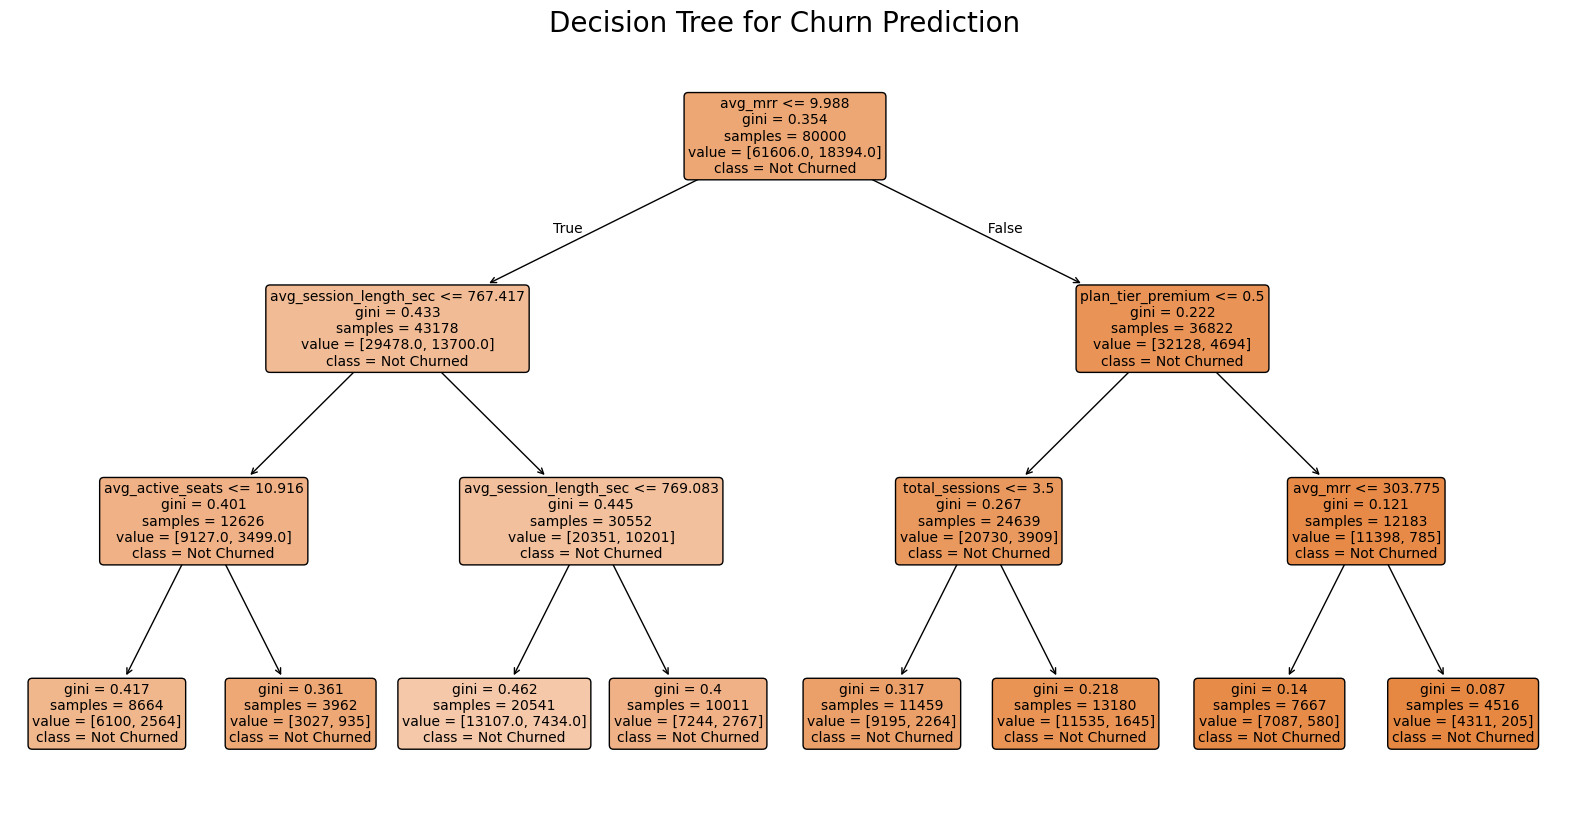

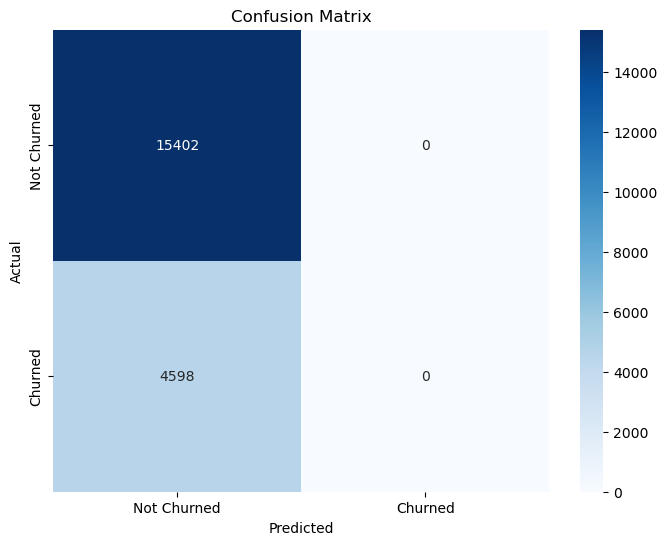

In [24]:
# Missing Values: median for numerical, mode for categorical
for col in X.select_dtypes(include=['number']).columns:
    X[col] = X[col].fillna(X[col].median())

for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col] = X[col].fillna(X[col].mode()[0])

# Encode Categorical Variables
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Train
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))


plt.figure(figsize=(20, 10))
plot_tree(
    dt_classifier,
    feature_names=X_encoded.columns,
    class_names=['Not Churned', 'Churned'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree for Churn Prediction", fontsize=20)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

Class imbalance issue: The model predict every case as NOT CHURNED

              precision    recall  f1-score   support

 Not Churned       0.87      0.52      0.65     15402
     Churned       0.32      0.75      0.45      4598

    accuracy                           0.57     20000
   macro avg       0.60      0.63      0.55     20000
weighted avg       0.75      0.57      0.60     20000



Text(0.5, 1.0, 'Confusion Matrix')

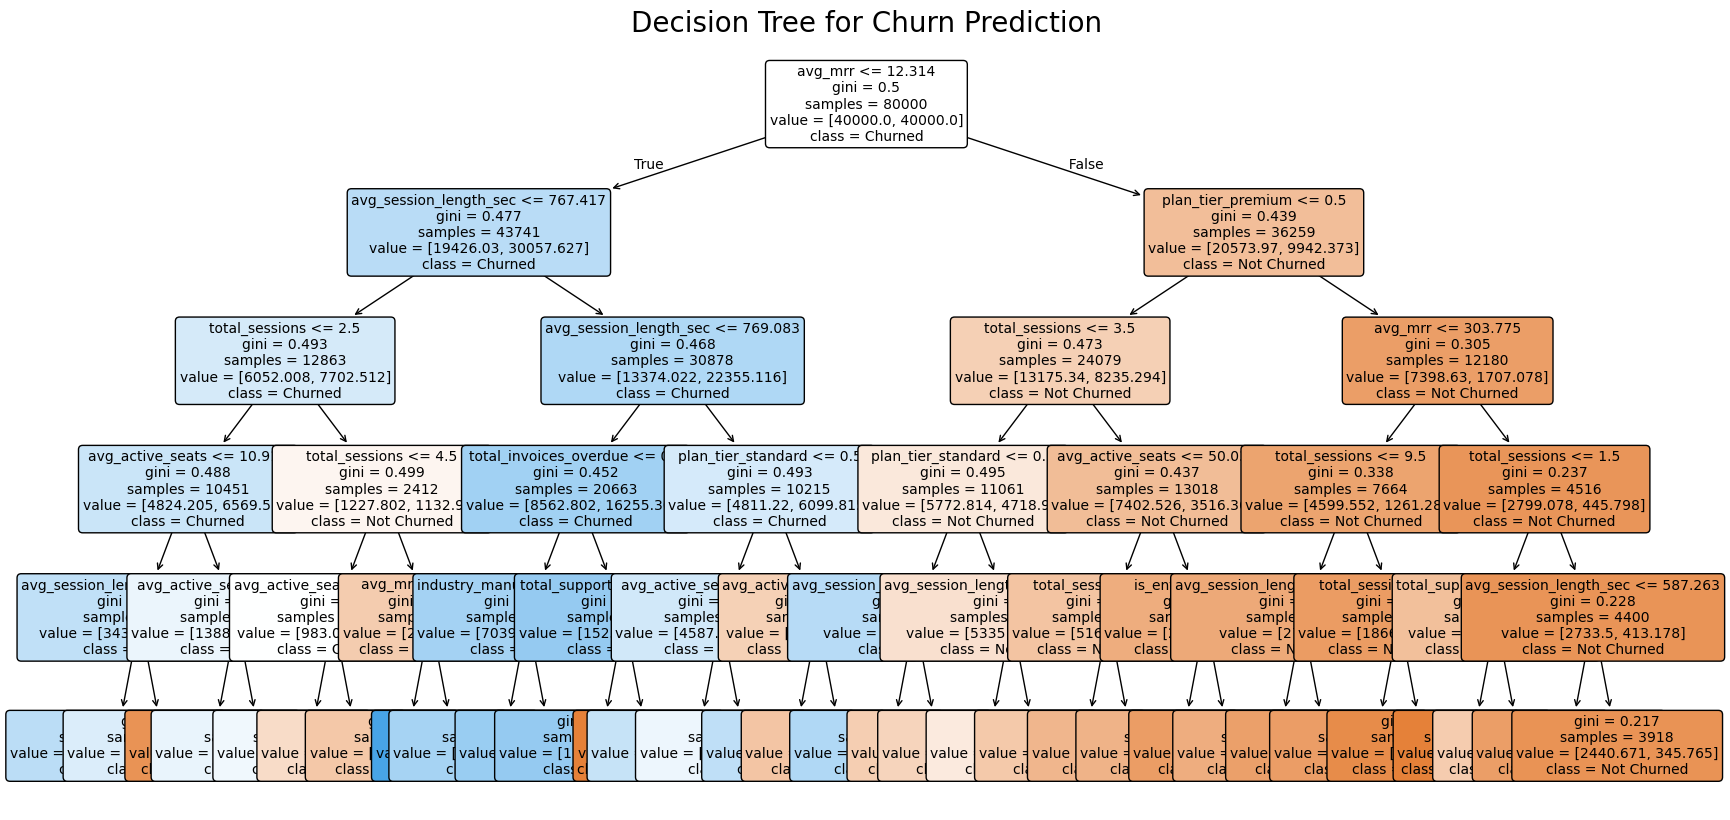

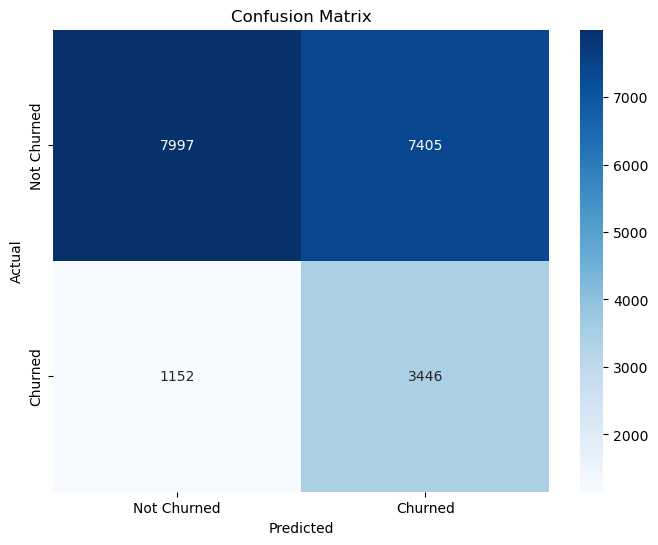

In [25]:
# Try different arguments
dt_classifier = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))


plt.figure(figsize=(20, 10))
plot_tree(
    dt_classifier,
    feature_names=X_encoded.columns,
    class_names=['Not Churned', 'Churned'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree for Churn Prediction", fontsize=20)

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

Not a great accuracy. Try a more complex / non-linear model. First check the correlation


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:23:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

 Not Churned       0.86      0.55      0.67     15402
     Churned       0.32      0.71      0.44      4598

    accuracy                           0.59     20000
   macro avg       0.59      0.63      0.56     20000
weighted avg       0.74      0.59      0.62     20000



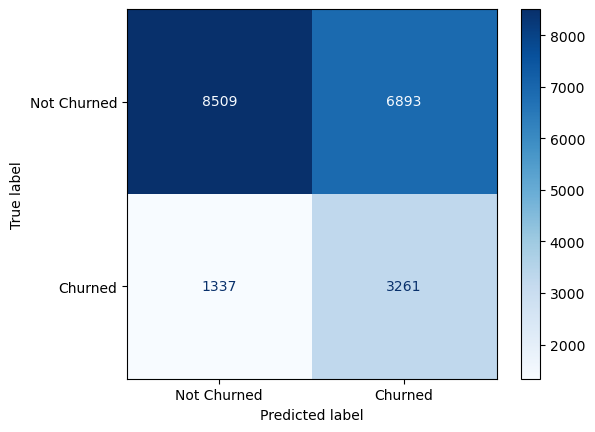

/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_94879/1936997304.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_20_features, palette='rocket')


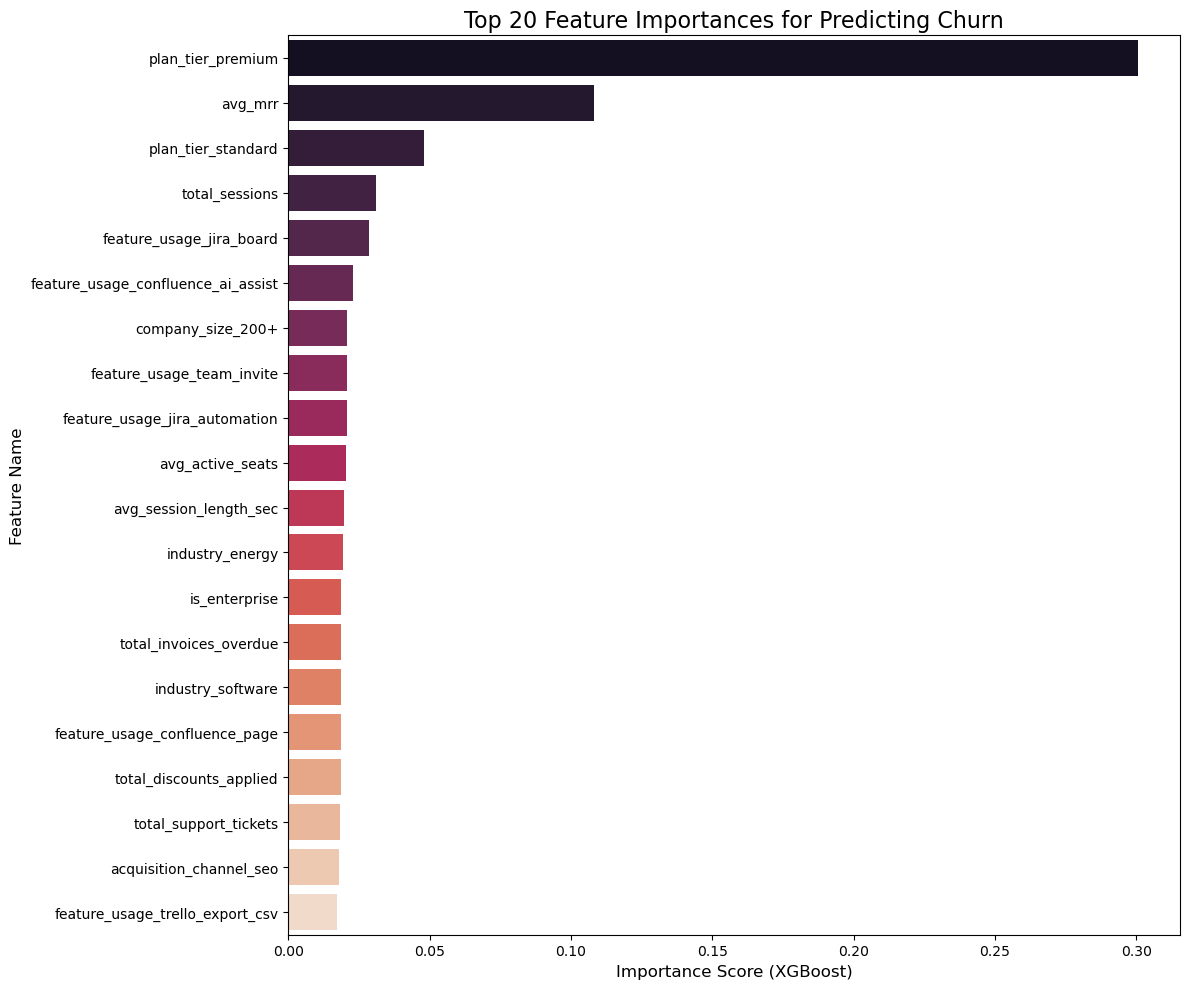

In [26]:
import xgboost as xgb

feature_counts = events_df.groupby(['user_id', 'feature_name']).size().unstack(fill_value=0)
feature_counts.columns = [f'feature_usage_{col.replace(" ", "_")}' for col in feature_counts.columns]
feature_counts.reset_index(inplace=True)

df = users_df.drop_duplicates(subset='user_id')
df = pd.merge(df, billing_agg, on='user_id', how='left')
df = pd.merge(df, sessions_agg, on='user_id', how='left')
df = pd.merge(df, feature_counts, on='user_id', how='left')


TARGET = 'churned_90d'
base_features = [
    'plan_tier', 'company_size', 'industry', 'acquisition_channel', 'is_enterprise',
    'avg_mrr', 'avg_active_seats', 'total_invoices_overdue', 'total_discounts_applied',
    'total_support_tickets', 'avg_session_length_sec', 'total_sessions'
]
feature_usage_cols = [col for col in df.columns if col.startswith('feature_usage_')]
features = base_features + feature_usage_cols
model_df = df[features + [TARGET]].copy()

# Missing Value
for col in feature_usage_cols:
    model_df[col] = model_df[col].fillna(0)
for col in model_df.select_dtypes(include=['float64', 'int64']).columns:
    if col != TARGET:
        model_df[col] = model_df[col].fillna(model_df[col].median())
for col in model_df.select_dtypes(include=['object']).columns:
    model_df[col] = model_df[col].fillna(model_df[col].mode()[0])

# One-hot encode categorical variables
model_df = pd.get_dummies(model_df, columns=model_df.select_dtypes(include=['object']).columns, drop_first=True)


X = model_df.drop(TARGET, axis=1)
y = model_df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance for XGBoost
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churned', 'Churned'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
top_20_features = feature_importance_df.head(20)


plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_20_features, palette='rocket')
plt.title('Top 20 Feature Importances for Predicting Churn', fontsize=16)
plt.xlabel('Importance Score (XGBoost)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.tight_layout()
plt.show()

Paid customer is less likely to churn. Prediction model has low accuracy, reflecting these features are not as effective.


churned_90d                            1.000000
total_sessions                         0.167500
plan_tier_premium                      0.166998
total_discounts_applied                0.142772
feature_usage_jira_board               0.139552
feature_usage_jira_automation          0.125074
plan_tier_standard                     0.122125
avg_mrr                                0.118538
feature_usage_team_invite              0.113426
avg_active_seats                       0.100551
total_support_tickets                  0.098530
feature_usage_bitbucket_integration    0.097325
feature_usage_confluence_page          0.093748
feature_usage_confluence_ai_assist     0.086882
is_enterprise                          0.073272
Name: churned_90d, dtype: float64


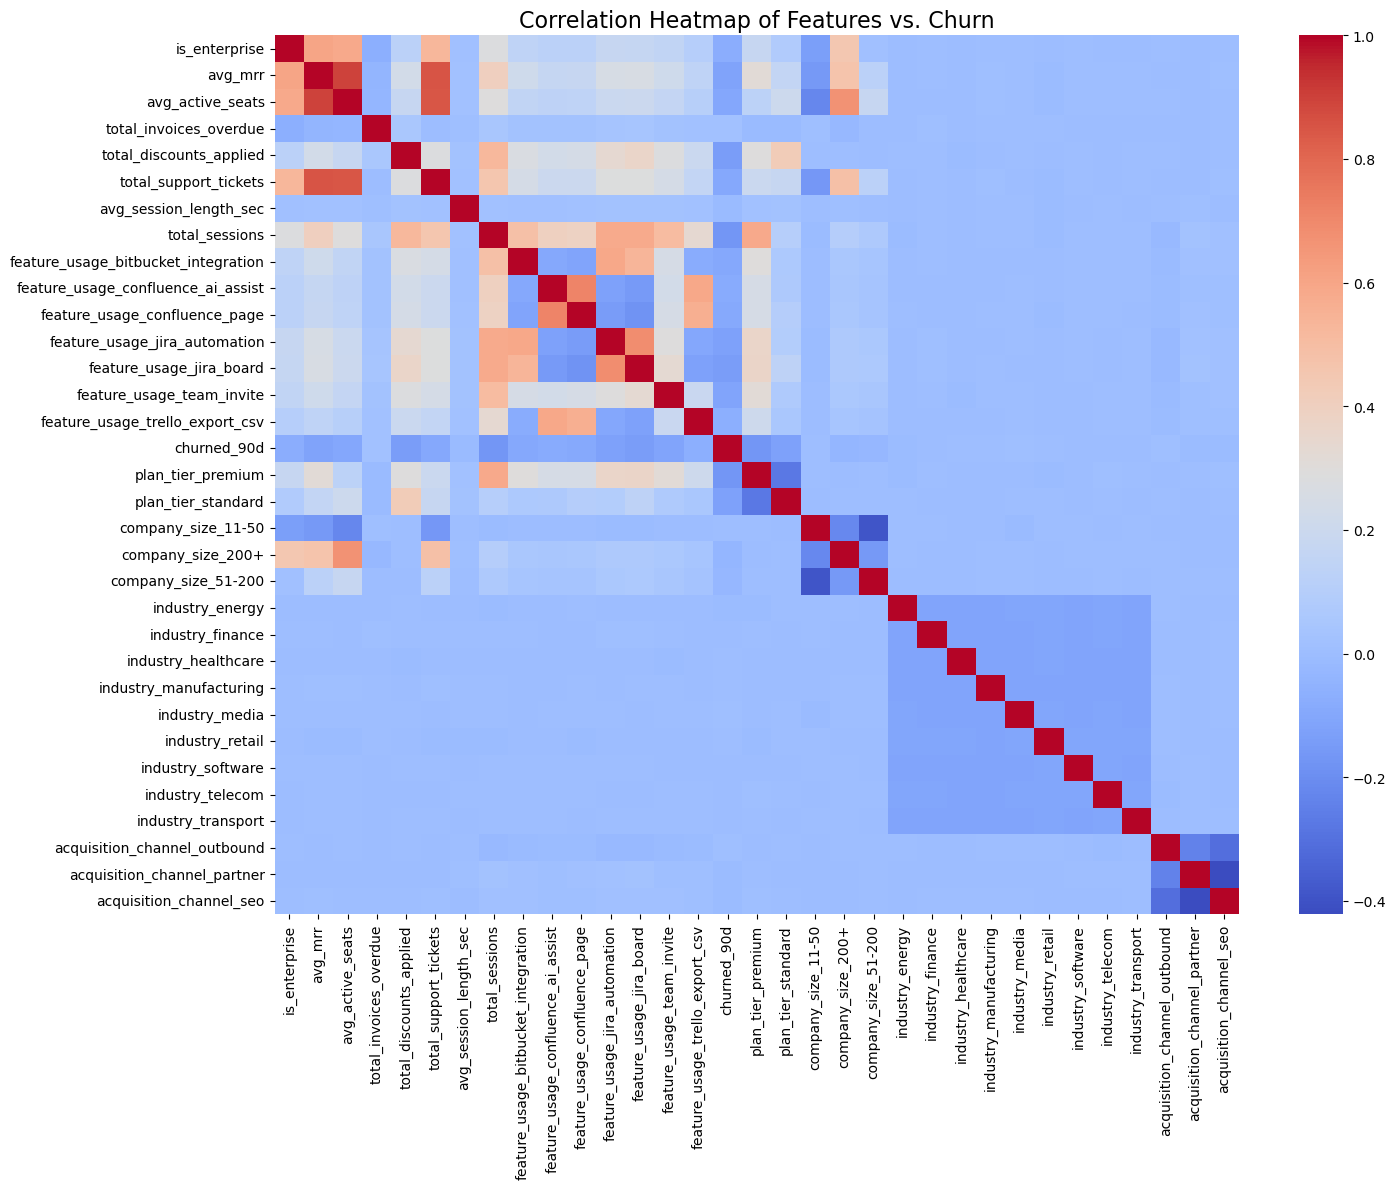

In [27]:

# One-hot encode categorical variables
model_df_encoded = pd.get_dummies(model_df, columns=model_df.select_dtypes(include=['object']).columns, drop_first=True)

plt.figure(figsize=(15, 12))
numerical_features = model_df_encoded.select_dtypes(include=['float64', 'int64', 'int32', 'uint8', 'bool']).columns
correlation_matrix = model_df_encoded[numerical_features].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Features vs. Churn', fontsize=16)
plt.tight_layout()

print(correlation_matrix[TARGET].abs().sort_values(ascending=False).head(15))

count    12960.000000
mean         7.642760
std          4.598541
min          0.000000
25%          3.833333
50%          7.300000
75%         11.233333
max         18.200000
Name: months_to_churn, dtype: float64


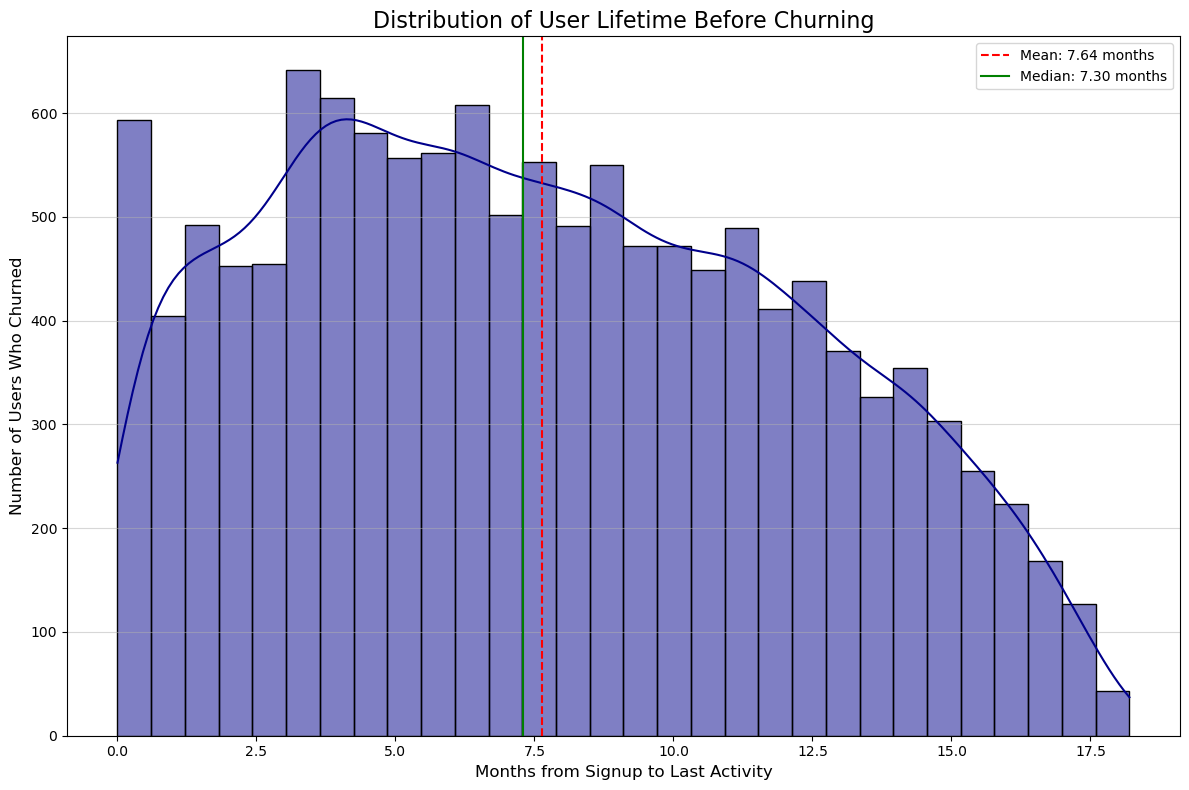

In [28]:

users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])
sessions_df['session_start'] = pd.to_datetime(sessions_df['session_start'])

# Find last session date for every user
last_session_df = sessions_df.groupby('user_id')['session_start'].max().reset_index()
last_session_df.rename(columns={'session_start': 'last_session_date'}, inplace=True)
users_with_last_session = pd.merge(users_df, last_session_df, on='user_id', how='left')

# calculate user lifetime for churned users
churned_users_df = users_with_last_session[users_with_last_session['churned_90d'] == 1].copy()
churned_users_df.dropna(subset=['last_session_date'], inplace=True)
churned_users_df['months_to_churn'] = ((churned_users_df['last_session_date'] - churned_users_df['signup_date']).dt.days ) / 30.0
churned_users_df = churned_users_df[churned_users_df['months_to_churn'] >= 0]

print(churned_users_df['months_to_churn'].describe())

plt.figure(figsize=(12, 8))
sns.histplot(data=churned_users_df, x='months_to_churn', bins=30, kde=True, color='darkblue')

# Add lines for mean/median in months
plt.axvline(churned_users_df['months_to_churn'].mean(), color='red', linestyle='--', label=f"Mean: {churned_users_df['months_to_churn'].mean():.2f} months")
plt.axvline(churned_users_df['months_to_churn'].median(), color='green', linestyle='-', label=f"Median: {churned_users_df['months_to_churn'].median():.2f} months")

plt.title('Distribution of User Lifetime Before Churning', fontsize=16)
plt.xlabel('Months from Signup to Last Activity', fontsize=12)
plt.ylabel('Number of Users Who Churned', fontsize=12)
plt.legend()
 # Focus on the 3-month window
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()

/var/folders/86/f0p_j94s7f1c8v5173hp7m9w0000gn/T/ipykernel_94879/1891263592.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=churned_users_df, x='plan_tier', y='months_to_churn', palette='coolwarm', order=['free', 'standard', 'premium'])


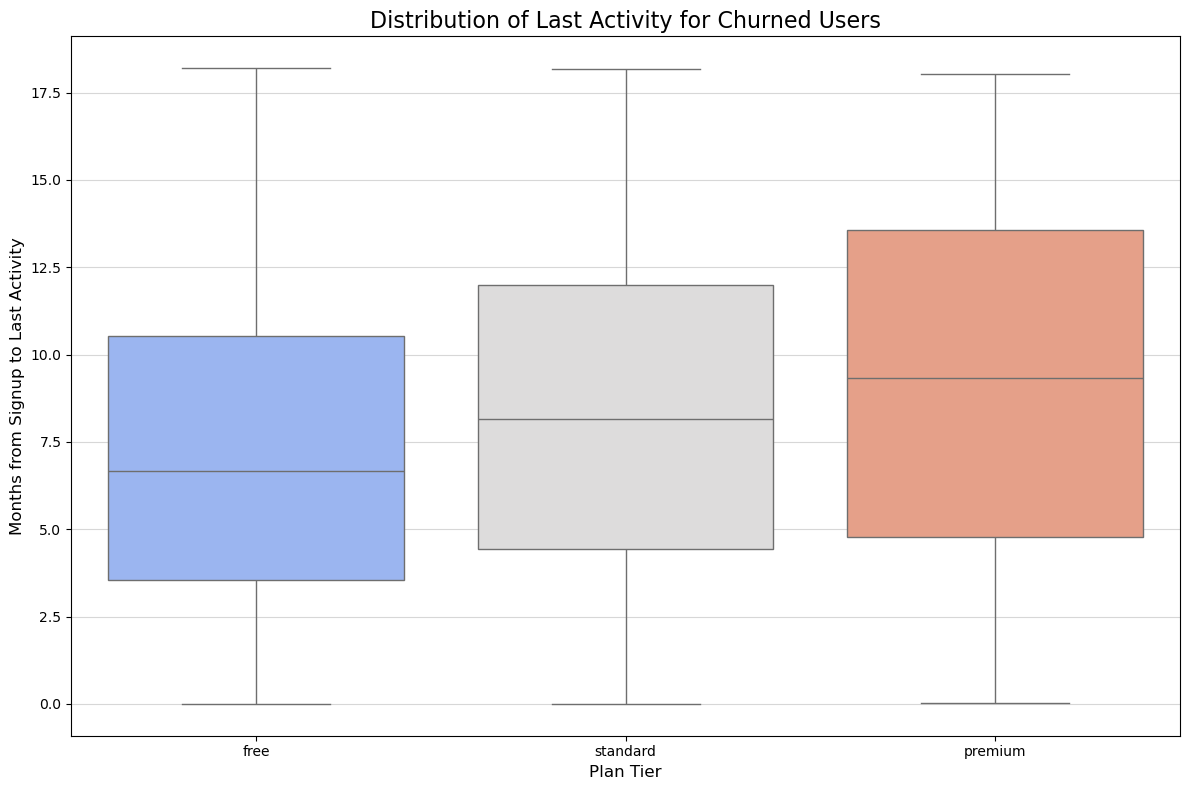

In [29]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=churned_users_df, x='plan_tier', y='months_to_churn', palette='coolwarm', order=['free', 'standard', 'premium'])

plt.title('Distribution of Last Activity for Churned Users', fontsize=16)
plt.xlabel('Plan Tier', fontsize=12)
plt.ylabel('Months from Signup to Last Activity', fontsize=12)
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()